In [1]:
%pip install ribs torch==1.7 torchvision==0.8 numpy matplotlib

  Using cached ribs-0.4.0-py3-none-any.whl (59 kB)
ERROR: Could not find a version that satisfies the requirement torch==1.7 (from versions: 1.11.0, 1.12.0, 1.12.1, 1.13.0, 1.13.1)
ERROR: No matching distribution found for torch==1.7
You should consider upgrading via the '/usr/local/bin/python3.10 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import sys
sys.path.append('/opt/miniconda3/lib/python3.10/site-packages')

import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [4]:
class Generator(nn.Module):
    """Generator network for the GAN."""

    def __init__(self, nz):
        super(Generator, self).__init__()

        # Size of the latent space (number of dimensions).
        self.nz = nz
        self.main = nn.Sequential(
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )

    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)


class Discriminator(nn.Module):
    """Discriminator network for the GAN."""

    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784
        self.main = nn.Sequential(
            nn.Linear(self.n_input, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x)


LENET5 = nn.Sequential(
    nn.Conv2d(1, 6, (5, 5), stride=1, padding=0),  # (1,28,28) -> (6,24,24)
    nn.MaxPool2d(2),  # (6,24,24) -> (6,12,12)
    nn.ReLU(),
    nn.Conv2d(6, 16, (5, 5), stride=1, padding=0),  # (6,12,12) -> (16,8,8)
    nn.MaxPool2d(2),  # (16,8,8) -> (16,4,4)
    nn.ReLU(),
    nn.Flatten(),  # (16,4,4) -> (256,)
    nn.Linear(256, 120),  # (256,) -> (120,)
    nn.ReLU(),
    nn.Linear(120, 84),  # (120,) -> (84,)
    nn.ReLU(),
    nn.Linear(84, 10),  # (84,) -> (10,)
    nn.LogSoftmax(dim=1),  # (10,) log probabilities
).to(device)
LENET5_MEAN_TRANSFORM = 0.1307
LENET5_STD_DEV_TRANSFORM = 0.3081

In [5]:
import os
from urllib.request import urlretrieve
from pathlib import Path

LOCAL_DIR = Path("lsi_mnist_weights")
LOCAL_DIR.mkdir(exist_ok=True)
WEB_DIR = "https://raw.githubusercontent.com/icaros-usc/pyribs/master/examples/tutorials/_static/"

# Download the model files to LOCAL_DIR.
for filename in [
        "mnist_generator.pth",
        "mnist_discriminator.pth",
        "mnist_classifier.pth",
]:
    model_path = LOCAL_DIR / filename
    if not model_path.is_file():
        urlretrieve(WEB_DIR + filename, str(model_path))

# Load the weights of each network from its file.
g_state_dict = torch.load(
    str(LOCAL_DIR / "mnist_generator.pth"),
    map_location=device,
)
d_state_dict = torch.load(
    str(LOCAL_DIR / "mnist_discriminator.pth"),
    map_location=device,
)
c_state_dict = torch.load(
    str(LOCAL_DIR / "mnist_classifier.pth"),
    map_location=device,
)

# Instantiate networks and insert the weights.
generator = Generator(nz=128).to(device)
discriminator = Discriminator().to(device)
generator.load_state_dict(g_state_dict)
discriminator.load_state_dict(d_state_dict)
LENET5.load_state_dict(c_state_dict)

<All keys matched successfully>

In [6]:
from ribs.archives import GridArchive

archive = GridArchive(
    [200, 200],  # 200 bins in each dimension.
    [(0, 784), (0.5, 1)],  # Boldness range, lightness range.
)

In [7]:
from ribs.emitters import ImprovementEmitter

emitters = [
    ImprovementEmitter(
        archive,
        np.zeros(generator.nz),
        0.2,
        batch_size=30,
    ) for _ in range(5)
]

In [8]:
from ribs.optimizers import Optimizer

optimizer = Optimizer(archive, emitters)

In [9]:
total_itrs = 30_000
flat_img_size = 784  # 28 * 28
start_time = time.time()

for itr in range(1, total_itrs + 1):
    sols = optimizer.ask()

    with torch.no_grad():
        tensor_sols = torch.tensor(
            sols,
            dtype=torch.float32,
            device=device,
        )

        # Shape: len(sols) x 1 x 28 x 28
        generated_imgs = generator(tensor_sols)

        # Normalize the images from [-1,1] to [0,1].
        normalized_imgs = (generated_imgs + 1.0) / 2.0

        # We optimize the score of the digit being 8. Other digits may also be
        # used.
        lenet5_normalized = ((normalized_imgs - LENET5_MEAN_TRANSFORM) /
                             LENET5_STD_DEV_TRANSFORM)
        objs = torch.exp(LENET5(lenet5_normalized)[:, 8]).cpu().numpy()

        # Shape: len(sols) x 784
        flattened_imgs = normalized_imgs.cpu().numpy().reshape(
            (-1, flat_img_size))

        # The first bc is the "boldness" of the digit (i.e. number of white
        # pixels). We consider pixels with values larger than or equal to 0.5
        # to be "white".
        # Shape: len(sols) x 1
        boldness = np.count_nonzero(flattened_imgs >= 0.5,
                                    axis=1,
                                    keepdims=True)

        # The second bc is the "lightness" of the digit (i.e. the mean value of
        # the white pixels).
        # Shape: len(sols) x 1
        flattened_imgs[flattened_imgs < 0.5] = 0  # Set non-white pixels to 0.
        # Add 1 to avoid dividing by zero.
        lightness = (np.sum(flattened_imgs, axis=1, keepdims=True) /
                     (boldness + 1))

        # Each BC entry is [boldness, lightness].
        bcs = np.concatenate([boldness, lightness], axis=1)

    optimizer.tell(objs, bcs)

    if itr % 1000 == 0:
        print(
            f"Iteration {itr} complete after {time.time() - start_time}s - "
            f"Archive size: {len(archive.as_pandas(include_solutions=False))}")

Iteration 1000 complete after 13.828688144683838s - Archive size: 13415
Iteration 2000 complete after 26.719810009002686s - Archive size: 14623
Iteration 3000 complete after 39.36929893493652s - Archive size: 15764
Iteration 4000 complete after 50.559849977493286s - Archive size: 16893
Iteration 5000 complete after 61.76767897605896s - Archive size: 17404
Iteration 6000 complete after 72.4151759147644s - Archive size: 17581
Iteration 7000 complete after 83.4462251663208s - Archive size: 17657
Iteration 8000 complete after 93.92383003234863s - Archive size: 17820
Iteration 9000 complete after 104.62879300117493s - Archive size: 18164
Iteration 10000 complete after 115.92664694786072s - Archive size: 18237
Iteration 11000 complete after 126.78807806968689s - Archive size: 18687
Iteration 12000 complete after 137.47808289527893s - Archive size: 18941
Iteration 13000 complete after 148.0670828819275s - Archive size: 19978
Iteration 14000 complete after 159.3376178741455s - Archive size: 20

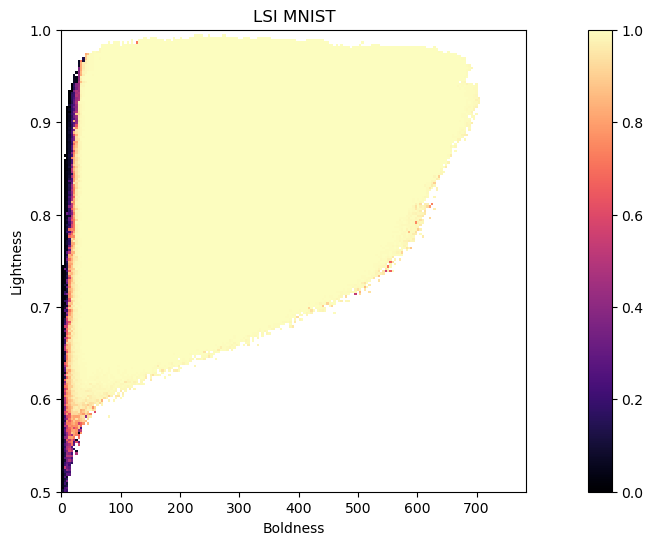

In [10]:
from ribs.visualize import grid_archive_heatmap

plt.figure(figsize=(8, 6))
grid_archive_heatmap(archive, vmin=0.0, vmax=1.0)
plt.title("LSI MNIST")
plt.xlabel("Boldness")
plt.ylabel("Lightness")
plt.show()

In [11]:
from torchvision.utils import make_grid


def show_grid_img(x_start,
                  x_num,
                  x_step_size,
                  y_start,
                  y_num,
                  y_step_size,
                  archive,
                  figsize=(8, 6)):
    """Displays a grid of images from the archive.
    
    Args:
        x_start (int): Starting index along x-axis.
        x_num (int): Number of images to generate along x-axis.
        x_step_size (int): Index step size along x-axis.
        y_start (int): Starting index along y-axis.
        y_num (int): Number of images to generate along y-axis.
        y_step_size (int): Index step size along y-axis.
        archive (GridArchive): Archive with results from CMA-ME.
        figsize ((int, int)): Size of the figure for the image.
    """
    x_range = np.arange(x_start, x_start + x_step_size * x_num, x_step_size)
    y_range = np.arange(y_start, y_start + y_step_size * y_num, y_step_size)
    grid_indices = [(x, y) for y in np.flip(y_range) for x in x_range]

    imgs = []
    img_size = (28, 28)
    df = archive.as_pandas()
    solutions, indices = df.batch_solutions(), df.batch_indices()
    for index in grid_indices:
        try:
            sol = solutions[indices.index(index)]
        except ValueError:
            print(f"There is no solution at index {index}.")
            return

        with torch.no_grad():
            img = generator(
                torch.tensor(sol.reshape(1, generator.nz),
                             dtype=torch.float32,
                             device=device))
            # Normalize images to [0,1].
            normalized = (img.reshape(1, *img_size) + 1) / 2
            imgs.append(normalized)

    plt.figure(figsize=figsize)
    img_grid = make_grid(imgs, nrow=x_num, padding=0)
    plt.imshow(np.transpose(img_grid.cpu().numpy(), (1, 2, 0)),
               interpolation='nearest',
               cmap='gray')

    # Change labels to be BC values.
    plt.xlabel("Boldness")
    plt.ylabel("Lightness")
    x_ticklabels = [
        round(archive.boundaries[0][i])
        for i in [x_start + x_step_size * k for k in range(x_num + 1)]
    ]
    y_ticklabels = [
        round(archive.boundaries[1][i], 2) for i in [
            y_start + y_step_size * y_num - y_step_size * k
            for k in range(y_num + 1)
        ]
    ]
    plt.xticks([img_size[0] * x for x in range(x_num + 1)], x_ticklabels)
    plt.yticks([img_size[0] * x for x in range(y_num + 1)], y_ticklabels)

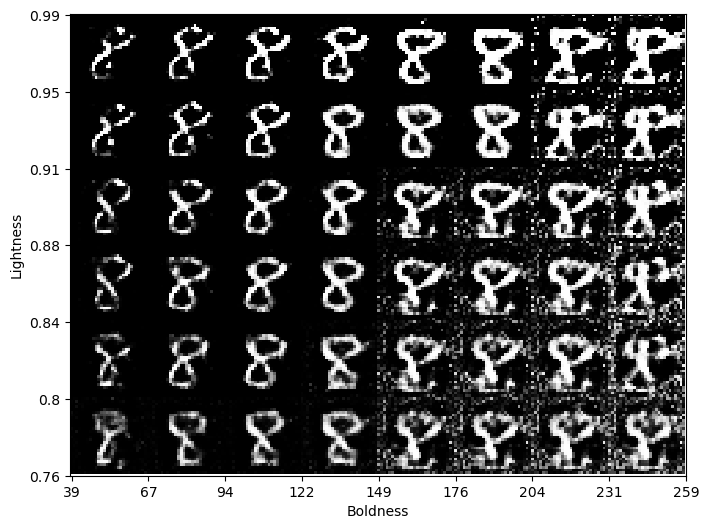

In [12]:
show_grid_img(10, 8, 7, 105, 6, 15, archive)

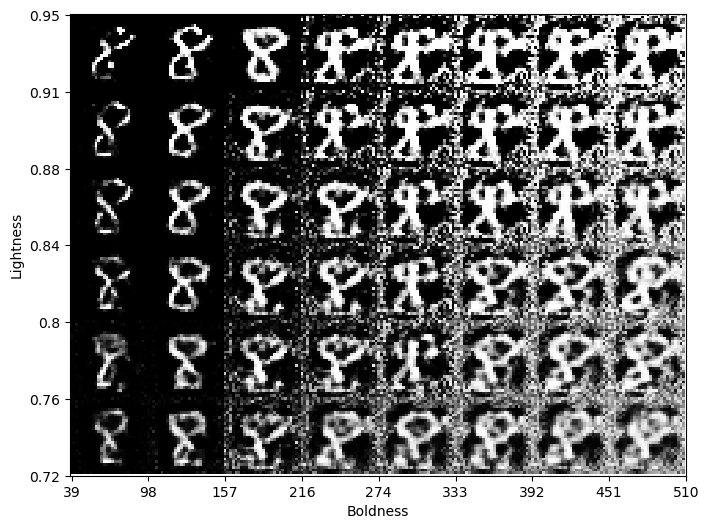

In [13]:
show_grid_img(10, 8, 15, 90, 6, 15, archive)

In [14]:
discriminator_archive = GridArchive(
    [200, 200],  # 200 bins in each dimension.
    [(0, 784), (0.5, 1)],  # Boldness range, lightness range.
)
discriminator_archive.initialize(generator.nz)

# Evaluate each solution in the archive and insert it into the new archive.
for elite in archive:
    # No need to normalize to [0, 1] since the discriminator takes in images in
    # the range [-1, 1].
    img = generator(
        torch.tensor(elite.sol.reshape(1, generator.nz),
                     dtype=torch.float32,
                     device=device))
    obj = discriminator(img).item()
    discriminator_archive.add(elite.sol, obj, elite.beh)

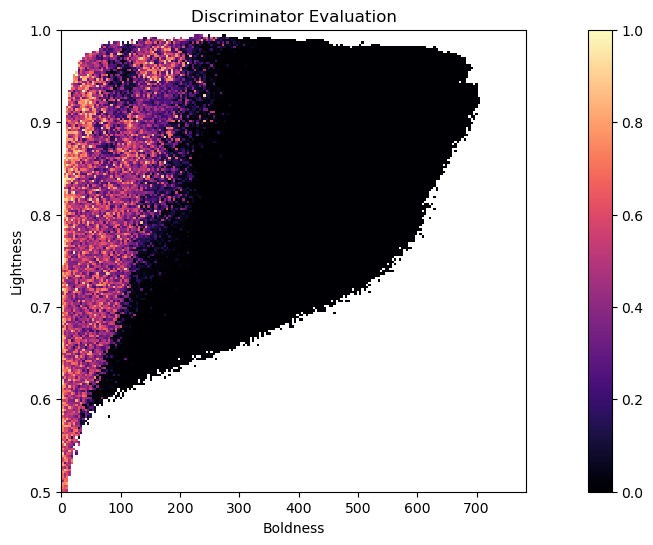

In [15]:
plt.figure(figsize=(8, 6))
grid_archive_heatmap(discriminator_archive, vmin=0.0, vmax=1.0)
plt.title("Discriminator Evaluation")
plt.xlabel("Boldness")
plt.ylabel("Lightness")
plt.show()